# All Weather Portfolio based on Hidden Markov Macro Regime Model

# Packages

In [4]:
import pandas as pd
import numpy as np
import statsmodels as sm
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from functools import reduce
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from numpy.linalg import slogdet, solve
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# 1. Data Processing 

## 1.1 Volatility Indicies

In [5]:
base_path = '~/Desktop/Data'
index_vol = pd.read_csv(f'{base_path}/Indices/VIX_Data/vix_data.csv')
vvix = pd.read_csv(f'{base_path}/Indices/VIX_Data/VVIX_History.csv')
vxv = pd.read_csv(f'{base_path}/Indices/VIX_Data/VIX3M.csv')
cesi = pd.read_csv(f'{base_path}/Indices/CESI_index.csv')

In [6]:
macro_base_path = '~/Desktop/Data/Macro/'

index_vol['Date'] = pd.to_datetime(index_vol['Date'], format='%Y-%m-%d')

vvix.rename(columns={'DATE': 'Date', 'VVIX': 'vvix'}, inplace=True)
vvix['Date'] = pd.to_datetime(vvix['Date'])

vxv.rename(columns={'PX_LAST': 'vxv'}, inplace=True)
vxv['Date'] = pd.to_datetime(vxv['Date'], format='%Y/%m/%d')
vxv = vxv[['Date', 'vxv']]

cesi.rename(columns={'PX_LAST': 'cesi'}, inplace=True)
cesi['Date'] = pd.to_datetime(cesi['Date'], format='%Y/%m/%d')
cesi = cesi[['Date', 'cesi']]

data_frames_to_merge = [index_vol, vvix, vxv, cesi]

volatility_df = data_frames_to_merge[0]

for df in data_frames_to_merge[1:]:
    volatility_df = pd.merge(volatility_df, df, on='Date', how='inner')

volatility_df = volatility_df.sort_values(by='Date')
volatility_df = volatility_df.set_index('Date')

volatility_df.dropna(how='all')

print(volatility_df.head())

             vixo   vixh   vixl    vix   vxno   vxnh   vxnl    vxn   vxdo  \
Date                                                                        
2006-03-06  12.22  12.91  12.22  12.74  16.60  17.71  16.58  17.52  11.74   
2006-03-15  11.17  11.54  10.98  11.35  15.59  15.65  14.90  15.44  10.88   
2006-03-16  10.59  12.05  10.57  11.98  15.54  15.75  15.08  15.62  10.82   
2006-03-17  11.56  12.20  11.53  12.12  15.55  15.60  14.90  15.36  10.80   
2006-03-20  11.23  12.21  11.13  11.79  15.96  16.24  15.76  15.93  11.19   

             vxdh   vxdl    vxd   vvix    vxv  cesi  
Date                                                 
2006-03-06  12.35  11.54  12.16  71.73  13.20 -45.1  
2006-03-15  11.07  10.74  10.77  15.71  12.28 -38.5  
2006-03-16  11.15  10.59  11.09  27.94  12.41 -40.1  
2006-03-17  11.08  10.60  10.87  28.60  12.63 -41.8  
2006-03-20  11.66  11.01  11.06  37.93  12.65 -40.5  


## 1.2 Global Macro Factors

In [7]:
# Growth Data

# 1. Load GDP Data
gdp_path = os.path.join(macro_base_path, 'GDP/US_GDP.csv')
gdp_df = pd.read_csv(gdp_path)

gdp_df.rename(columns={'observation_date': 'Date'}, inplace=True)
gdp_df['Date'] = pd.to_datetime(gdp_df['Date'], errors='coerce')
gdp_df.dropna(subset=['Date'], inplace=True)
gdp_df = gdp_df[['Date', 'GDP']]

# 2. Load and Combine PMI Data
pmi_path = os.path.join(macro_base_path, 'PMI')

pmi_filenames = [
    "China_Manufacture_PMI.csv",
    "Hungary_Manufacture_PMI.csv",
    "Isarel_Manufacture_PMI.csv",
    "NewZealand_Manufacture_PMI.csv",
    "Norway_Manufacture_PMI.csv",
    "Singapore_Manufacture_PMI.csv",
    "SouthAfrica_Manufacture_PMI.csv",
    "Sweden_Manufacture_PMI.csv",
    "Switzerland_Manufacture_PMI.csv",
    "US_Manufacture_PMI.csv"
]

all_pmi_files = [os.path.join(pmi_path, f) for f in pmi_filenames]

pmi_df_list = []
for f_path in all_pmi_files:

    df = pd.read_csv(f_path)
        
    f_name = os.path.basename(f_path)
    country_name = f_name.split('_')[0]
        
    df.rename(columns={'DateTime': 'Date', 'Close': f'PMI_{country_name}'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[['Date', f'PMI_{country_name}']]
    df.dropna(subset=['Date'], inplace=True)
    pmi_df_list.append(df)

pmi_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), pmi_df_list)
gdp_df = gdp_df.set_index('Date').sort_index()

pmi_df = pmi_df.set_index('Date').sort_index()
start_date = min(gdp_df.index.min(), pmi_df.index.min())
end_date = pmi_df.index.max() 
daily_index = pd.date_range(start=start_date, end=end_date, freq='B')
pmi_reindexed = pmi_df.reindex(daily_index)
gdp_ffilled = gdp_df.reindex(daily_index, method='ffill')

growth_df = pd.merge(pmi_reindexed, gdp_ffilled, left_index=True, right_index=True, how='left')
growth_df.fillna(method='ffill', inplace=True)
growth_df.dropna(inplace=True)
growth_df.index.name = 'Date'
    
print(growth_df.head())

            PMI_China  PMI_Hungary  PMI_Isarel  PMI_NewZealand  PMI_Norway  \
Date                                                                         
2005-11-30       54.1        55.54        57.7            44.3       60.02   
2005-12-01       54.1        55.54        57.7            44.3       60.02   
2005-12-02       54.1        55.54        57.7            44.3       60.02   
2005-12-05       54.1        55.54        57.7            44.3       60.02   
2005-12-06       54.1        55.54        57.7            44.3       60.02   

            PMI_Singapore  PMI_SouthAfrica  PMI_Sweden  PMI_Switzerland  \
Date                                                                      
2005-11-30           53.5            52.06        57.4             56.5   
2005-12-01           53.5            52.06        57.4             56.5   
2005-12-02           53.5            52.06        57.4             56.5   
2005-12-05           53.5            52.06        57.4             56.5   
200

/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_58116/2187268818.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  growth_df.fillna(method='ffill', inplace=True)


In [8]:
# Inflation Data

inflation_path = os.path.join(base_path, 'Macro/Inflation')
energy_path = os.path.join(base_path, 'Commodities/Energy')

inflation_filenames = [
    "Australia_cpi.csv", "canada_cpi.csv", "eu_cpi.csv",
    "euro_cpi.csv", "german_cpi.csv", "japan_cpi.csv", "new_zealand_cpi.csv",
    "norway_cpi.csv", "us_core_inflation.csv",
    "us_core_inflation_mom.csv", "us_cpi_core.csv", "us_cpi_housing.csv", "us_cpi_seasonaladjusted.csv", "us_cpi_transport.csv",
    "us_cpi.csv", "us_inflation_mom.csv", "us_inflation.csv", "us_PCEPI.csv"
]

energy_filenames = ["Crude Oil.csv"]

def load_and_prep(file_path, prefix=""):
    """Loads a single CSV, standardizes Date, and renames Close column."""
    try:
        df = pd.read_csv(file_path)
        
        # Get clean name from filename
        f_name = os.path.basename(file_path)
        clean_name = f_name.replace('.csv', '').replace('Manufacturing_', '')
        
        # Standardize Date column
        if 'DATE' in df.columns:
            df.rename(columns={'DATE': 'Date'}, inplace=True)
        elif 'DateTime' in df.columns:
            df.rename(columns={'DateTime': 'Date'}, inplace=True)
        elif 'observation_date' in df.columns:
            df.rename(columns={'observation_date': 'Date'}, inplace=True)
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            
            new_col_name = f"{prefix}{clean_name}"
            df.rename(columns={'Close': new_col_name}, inplace=True)

            df = df[['Date', new_col_name]]
            df.dropna(subset=['Date'], inplace=True)
            return df
        else:
            print(f"Warning: 'Date' column not found in {file_path}. Skipping.")
            return None
            
    except FileNotFoundError:
        print(f"Warning: File not found at {file_path}. Skipping.")
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

all_dfs = []

# Load Inflation files
for f in inflation_filenames:
    df = load_and_prep(os.path.join(inflation_path, f), prefix="INF_")
    if df is not None:
        all_dfs.append(df)

# Load Energy files
for f in energy_filenames:
    df = load_and_prep(os.path.join(energy_path, f), prefix="COM_")
    if df is not None:
        all_dfs.append(df)

print(f"Successfully loaded {len(all_dfs)} files.")

# Combine all dataframes using an outer join on Date
inflation_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), all_dfs)
inflation_df = inflation_df.set_index('Date').sort_index()

# Create a full business-day index
start_date = inflation_df.index.min()
end_date = inflation_df.index.max() 
daily_index = pd.date_range(start=start_date, end=end_date, freq='B')

# Reindex and forward-fill all monthly/quarterly data
inflation_df = inflation_df.reindex(daily_index)
inflation_df.fillna(method='ffill', inplace=True)
    
# Calculate YoY for Crude Oil
crude_col = 'COM_Crude Oil'
inflation_df[f'{crude_col}_YoY'] = (inflation_df[crude_col] / inflation_df[crude_col].shift(252) - 1) * 100

inflation_df.dropna(how='any', inplace=True)
    
inflation_df.index.name = 'Date'

print("\n Inflation DataFrame Head")
print(inflation_df.head())

Successfully loaded 19 files.

 Inflation DataFrame Head
            INF_Australia_cpi  INF_canada_cpi  INF_eu_cpi  INF_euro_cpi  \
Date                                                                      
2000-12-21               70.2            96.6       75.28         76.68   
2000-12-22               70.2            96.6       75.28         76.68   
2000-12-25               70.2            96.6       75.28         76.68   
2000-12-26               70.2            96.6       75.28         76.68   
2000-12-27               70.2            96.6       75.28         76.68   

            INF_german_cpi  INF_japan_cpi  INF_new_zealand_cpi  \
Date                                                             
2000-12-21            75.8           97.0                692.2   
2000-12-22            75.8           97.0                692.2   
2000-12-25            75.8           97.0                692.2   
2000-12-26            75.8           97.0                692.2   
2000-12-27           

/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_58116/2180728788.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inflation_df.fillna(method='ffill', inplace=True)


In [9]:
# 3. Interest Rates (Yields)
def prepare_date_df(df):
    """Standardizes Date column and converts columns to numeric."""
    df = df.copy()
    if 'DATE' in df.columns:
        df.rename(columns={'DATE': 'Date'}, inplace=True)
    if 'DateTime' in df.columns:
        df.rename(columns={'DateTime': 'Date'}, inplace=True)
        
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.set_index('Date').sort_index()
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

base_path = os.path.expanduser('~/Desktop/Data/')
treasury_path = os.path.join(base_path, 'Macro/Treasury Yield')
indices_path = os.path.join(base_path, 'Indices')

bill_rate = prepare_date_df(pd.read_csv(os.path.join(treasury_path, 'Treasury Bill Yield/treasury_bill_yield_2002_2025.csv')))
par_yield = prepare_date_df(pd.read_csv(os.path.join(treasury_path, 'Treasury Par Yield/treasury_par_yield_2000_2025.csv')))
par_yield_real = prepare_date_df(pd.read_csv(os.path.join(treasury_path, 'Treasury Par Yield_Real/treasury_par_yield_real_2003_2025.csv')))

hy_oas = prepare_date_df(pd.read_csv(os.path.join(indices_path, 'HY_OAS.csv'))).rename(columns={'PX_LAST': 'HY_OAS'})
ig_oas = prepare_date_df(pd.read_csv(os.path.join(indices_path, 'IG_OAS.csv'))).rename(columns={'PX_LAST': 'IG_OAS'})

features_df = pd.DataFrame()
features_df['TBill_3M'] = bill_rate['13 WEEKS COUPON EQUIVALENT']
features_df['TNote_10Y'] = par_yield['10 Yr']
features_df['TNote_2Y'] = par_yield['2 Yr']
features_df['TIPS_10Y'] = par_yield_real['10 YR']
features_df['TIPS_5Y'] = par_yield_real['5 YR']
features_df['HY_OAS'] = hy_oas['HY_OAS']
features_df['IG_OAS'] = ig_oas['IG_OAS']

all_data_merged = features_df

start_date = all_data_merged.index.min()
end_date = all_data_merged.index.max()
daily_index = pd.date_range(start=start_date, end=end_date, freq='B')

rates_features = all_data_merged.reindex(daily_index)
rates_features.fillna(method='ffill', inplace=True)

rates_features.dropna(how='any', inplace=True)
rates_features.index.name = 'Date'

# Calculate spreads
rates_features['Curve_Slope_10Y2Y'] = rates_features['TNote_10Y'] - rates_features['TNote_2Y']
rates_features['Curve_Slope_10Y3M'] = rates_features['TNote_10Y'] - rates_features['TBill_3M']
rates_features['Curve_Slope_Real_10Y5Y'] = rates_features['TIPS_10Y'] - rates_features['TIPS_5Y']
rates_features['Credit_Spread_HYIG'] = rates_features['HY_OAS'] - rates_features['IG_OAS']

print("\n--- Rates Features Tail ---")
print(rates_features.head())


--- Rates Features Tail ---
            TBill_3M  TNote_10Y  TNote_2Y  TIPS_10Y  TIPS_5Y  HY_OAS  IG_OAS  \
Date                                                                           
2003-01-02      1.22       4.07      1.80      2.43     1.75    8.29    1.82   
2003-01-03      1.22       4.05      1.79      2.43     1.75    8.27    1.81   
2003-01-06      1.21       4.09      1.84      2.46     1.79    8.18    1.79   
2003-01-07      1.19       4.04      1.77      2.42     1.76    8.11    1.76   
2003-01-08      1.19       4.00      1.71      2.29     1.68    8.09    1.76   

            Curve_Slope_10Y2Y  Curve_Slope_10Y3M  Curve_Slope_Real_10Y5Y  \
Date                                                                       
2003-01-02               2.27               2.85                    0.68   
2003-01-03               2.26               2.83                    0.68   
2003-01-06               2.25               2.88                    0.67   
2003-01-07               2.27 

/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_58116/1413237847.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rates_features.fillna(method='ffill', inplace=True)


# 2. Feature Engineering

## 2.1 Vol Features

In [10]:
vol_raw = volatility_df.copy()
vol_features = volatility_df.copy()

def z_score(series, window):
    roll_mean = series.rolling(window=window, min_periods=window // 2).mean()
    roll_std = series.rolling(window=window, min_periods=window // 2).std()
    return (series - roll_mean) / roll_std

    
# 1. Term structure / contango
vol_features['VIX_TERM'] = vol_raw['vxv'] / vol_raw['vix']
vol_features['DOW_TERM'] = vol_raw['vxdh'] / vol_raw['vxd'] 
vol_features['NASDAQ_TERM'] = vol_raw['vxnh'] / vol_raw['vxn']
vol_features['Contango'] = (vol_features['VIX_TERM'] > 1).astype(int)

# 2. Skew / high-low ratios
vol_features['VIX_SKEW'] = vol_raw['vixh'] / vol_raw['vixl']
vol_features['VXN_SKEW'] = vol_raw['vxnh'] / vol_raw['vxnl']
vol_features['VXD_SKEW'] = vol_raw['vxdh'] / vol_raw['vxdl']

# 3. Cross-index spreads
vol_features['TECH_RISK_PREM'] = vol_raw['vxn'] - vol_raw['vix']
vol_features['INDUSTRIAL_RISK_PREM'] = vol_raw['vxd'] - vol_raw['vix']

# 4. Vol of vol / jump risk
vol_features['VVIX_z63'] = z_score(vol_raw['vvix'], 63)
vol_features['VVIX_MINUS_VIX'] = vol_raw['vvix'] - vol_raw['vix']

# 5. Level & momentum
for prefix in ['vix', 'vxn', 'vxd']:
    # Z-score (Level)
    vol_features[f'{prefix.upper()}_z63'] = z_score(vol_raw[prefix], 63)
        
    # Momentum (Price Change)
    vol_features[f'D_{prefix.upper()}_5D'] = vol_raw[prefix].diff(5)
        
    # RV_RATIO (Ratio of Level Z-Scores, as per image)
    z_21 = z_score(vol_raw[prefix], 21)
    z_252 = z_score(vol_raw[prefix], 252)
    vol_features[f'RV_RATIO_{prefix.upper()}'] = z_21 / z_252

# 6. Macro surprise overlay
vol_features['CESI_z63'] = z_score(vol_raw['cesi'], 63)
vol_features['D_CESI_20D'] = vol_raw['cesi'].diff(20)
    
# Combo feature: VIX_TERM * (CESI_z<0)
cesi_signal = (vol_features['CESI_z63'] < 0).astype(int)
vol_features['VIX_TERM_CESI'] = vol_features['VIX_TERM'] * cesi_signal

engineered_features = vol_features.drop(columns=vol_raw.columns)
engineered_features = engineered_features.dropna()

engineered_features.head()

,VIX_TERM,DOW_TERM,NASDAQ_TERM,Contango,VIX_SKEW,VXN_SKEW,VXD_SKEW,TECH_RISK_PREM,INDUSTRIAL_RISK_PREM,VVIX_z63,...,RV_RATIO_VIX,VXN_z63,D_VXN_5D,RV_RATIO_VXN,VXD_z63,D_VXD_5D,RV_RATIO_VXD,CESI_z63,D_CESI_20D,VIX_TERM_CESI
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-24,1.158434,1.000000,1.013470,1,1.028409,1.025308,1.023506,4.86,-0.28,-1.064457,...,-0.016290,-1.527818,0.23,0.539847,-0.836453,0.60,-0.036975,-0.635512,-12.9,1.158434
2006-11-27,1.091057,1.015886,1.014205,1,1.106822,1.079855,1.117755,5.30,-0.34,-0.546411,...,-7.054302,0.050912,2.27,-1.971220,1.031330,2.19,-8.902933,-0.445055,-2.9,1.091057
2006-11-28,1.117040,1.078761,1.042123,1,1.085640,1.053676,1.083556,5.71,-0.32,-1.011467,...,-2.031379,-0.162382,2.20,-1.256289,0.230101,1.55,-2.192251,-0.913226,-12.1,1.117040
2006-11-29,1.136657,1.037453,1.026818,1,1.071228,1.057055,1.051233,5.95,-0.15,-1.560986,...,-0.005928,-0.595521,1.76,-0.433600,-0.523482,1.08,-0.268601,-0.518836,2.6,1.136657
2006-11-30,1.144821,1.430320,1.046582,1,1.068053,1.067901,2.063859,5.62,-0.29,-1.406245,...,-0.172005,-0.777968,1.58,-0.182111,-0.575649,0.88,-0.153572,-0.805863,2.0,1.144821


## 2.2 Growth Features

In [11]:
growth_raw = growth_df.copy()
growth_features = growth_df.copy()

# 7. Diffusion/breadth
growth_features['PMI_US_ABOVE50'] = growth_raw['PMI_US'] - 50

g10_cols = [
    'PMI_US', 'PMI_China', 'PMI_NewZealand', 
    'PMI_Norway', 'PMI_Sweden', 'PMI_Switzerland'
]
available_g10_cols = [col for col in g10_cols if col in growth_raw.columns]
above_50 = (growth_raw[available_g10_cols] > 50).sum(axis=1)
growth_features['PMI_BREADTH_G6'] = above_50 / len(available_g10_cols)

# 8. PMI momentum & surprise
growth_features['PMI_US_MOM'] = growth_raw['PMI_US'].diff(21)
growth_features['PMI_US_Z252'] = z_score(growth_raw['PMI_US'], 252)
growth_features['PMI_SURPRISE'] = growth_raw['PMI_US'] - growth_raw['PMI_US'].rolling(252).mean()

# 9. GDP growth proxy
growth_features['GDP_YOY'] = (growth_raw['GDP'] / growth_raw['GDP'].shift(252) - 1) * 100
growth_features['D_GDP_YOY_20D'] = growth_features['GDP_YOY'].diff(20)
growth_features['GDP_YOY_z252'] = z_score(growth_features['GDP_YOY'], 252)

growth_features = growth_features.drop(columns=growth_raw.columns)
growth_features = growth_features.dropna()

growth_features.tail()

,PMI_US_ABOVE50,PMI_BREADTH_G6,PMI_US_MOM,PMI_US_Z252,PMI_SURPRISE,GDP_YOY,D_GDP_YOY_20D,GDP_YOY_z252
Date,,,,,,,,
2025-09-24,-2.0,0.500000,0.0,-0.521100,-0.607937,2.214729,-1.085881,-2.742772
2025-09-25,-2.0,0.500000,0.0,-0.523459,-0.609921,2.214729,-1.085881,-2.693415
2025-09-26,-2.0,0.500000,0.0,-0.525826,-0.611905,2.214729,-1.085881,-2.646261
2025-09-29,-2.0,0.500000,0.0,-0.528202,-0.613889,2.214729,-1.085881,-2.601145
2025-09-30,-0.9,0.166667,1.1,0.413416,0.479762,2.214729,-1.085881,-2.557920


## 2.3 Inflation Features

In [12]:
inflation_raw = inflation_df.copy()
inf_features = inflation_df.copy()

# 10. Inflation Level & Momentum
inf_features['CPI_US_YOY'] = (inflation_raw['INF_us_cpi'] / inflation_raw['INF_us_cpi'].shift(252) - 1) * 100
inf_features['CPI_US_MOM'] = inf_features['CPI_US_YOY'].diff(21)
inf_features['CPI_DIFF_US_minus_EUR'] = inflation_raw['INF_us_cpi'] - inflation_raw['INF_euro_cpi']

# 11. Inflation Breadth 
cpi_cols = [
    'INF_Australia_cpi', 'INF_canada_cpi', 'INF_china_cpi', 'INF_eu_cpi',
    'INF_euro_cpi', 'INF_german_cpi', 'INF_japan_cpi', 'INF_new_zealand_cpi',
    'INF_norway_cpi', 'INF_us_cpi'
]
available_cpi_cols = [col for col in cpi_cols if col in inflation_raw.columns]
yoy_cpi_df = (inflation_raw[available_cpi_cols] / inflation_raw[available_cpi_cols].shift(252) - 1) * 100
over_2_percent = (yoy_cpi_df > 2).sum(axis=1)
inf_features['CPI_BREADTH'] = over_2_percent / len(available_cpi_cols)

# 12. Oil Pass-through
crude_col = 'COM_Crude Oil'
crude_yoy_col = 'COM_Crude Oil_YoY'
inf_features.rename(columns={crude_yoy_col: 'WTI_YOY'}, inplace=True, errors='ignore')
wti_yoy_col_name = 'WTI_YOY'
inf_features['WTI_MOM_63D'] = inflation_raw[crude_col].diff(63)
median_1y_wti = inflation_raw[crude_col].rolling(252).median()
inf_features['WTI_BREAK'] = (inflation_raw[crude_col] > median_1y_wti).astype(int)

# 13. Inflation Regime Score
inf_features['INFL_REGIME'] = z_score(inf_features['CPI_US_YOY'], 252) + z_score(inf_features[wti_yoy_col_name], 252)

cols_to_drop = [col for col in inflation_raw.columns if col in inf_features.columns]
inflation_features = inf_features.drop(columns=cols_to_drop)
inflation_features = inflation_features.dropna()
inflation_features.tail()

,WTI_YOY,CPI_US_YOY,CPI_US_MOM,CPI_DIFF_US_minus_EUR,CPI_BREADTH,WTI_MOM_63D,WTI_BREAK,INFL_REGIME
Date,,,,,,,,
2025-11-10,-14.222539,2.89552,-0.117483,195.37,0.666667,-2.52,0,0.657671
2025-11-11,-14.317799,2.89552,-0.117483,195.37,0.666667,-2.92,0,0.650353
2025-11-12,-15.158109,2.89552,-0.117483,195.37,0.666667,-4.31,0,0.542102
2025-11-13,-14.657554,2.89552,-0.117483,195.37,0.666667,-4.73,0,0.612772
2025-11-14,-12.427241,2.89552,-0.117483,195.37,0.666667,-2.17,0,0.916756


In [13]:
wti_break_counts = inflation_features['WTI_BREAK'].value_counts()
wti_break_counts

WTI_BREAK
1    3695
0    2425
Name: count, dtype: int64

## 2.4 Cross-Asset Features

In [36]:
data_frames_to_merge = [
    engineered_features,
    growth_features,
    inflation_features,
    rates_features
]

features_df = reduce(
    lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), 
    data_frames_to_merge
)

# 15. Risk-on/off score
hy_oas_z63 = z_score(features_df['HY_OAS'], 63)
features_df['RISK_SCORE'] = -features_df['VIX_z63'] + features_df['CESI_z63'] - hy_oas_z63
    
# 16. Liquidity/QE proxy
# Need CB Balance Sheets Later
breakeven_10y_neg = features_df['TIPS_10Y'] - features_df['TNote_10Y']
features_df['TERM_PREMIUM_PROXY'] = z_score(breakeven_10y_neg, 252)
    
# QE_SCORE = -z(Curve_Slope_10Y3M, 252) - z(HY_OAS, 252) - z(VIX_TERM, 252)
z_curve_252 = z_score(features_df['Curve_Slope_10Y3M'], 252)
z_hy_oas_252 = z_score(features_df['HY_OAS'], 252)
z_vix_term_252 = z_score(features_df['VIX_TERM'], 252)
features_df['QE_SCORE'] = -z_curve_252 - z_hy_oas_252 - z_vix_term_252

# 17. Carry safety switch
features_df['CARRY_SAFETY_SWITCH'] = ((features_df['RISK_SCORE'] > 0) & (features_df['VIX_TERM'] > 1)).astype(int)

feat_cols_drop = ['TBill_3M','TNote_10Y','TNote_2Y','TIPS_10Y','TIPS_5Y','HY_OAS','IG_OAS']
features_df = features_df.drop(columns=feat_cols_drop)

features_df = features_df.dropna(how='any')
features_df.head()

,VIX_TERM,DOW_TERM,NASDAQ_TERM,Contango,VIX_SKEW,VXN_SKEW,VXD_SKEW,TECH_RISK_PREM,INDUSTRIAL_RISK_PREM,VVIX_z63,...,WTI_BREAK,INFL_REGIME,Curve_Slope_10Y2Y,Curve_Slope_10Y3M,Curve_Slope_Real_10Y5Y,Credit_Spread_HYIG,RISK_SCORE,TERM_PREMIUM_PROXY,QE_SCORE,CARRY_SAFETY_SWITCH
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-08,0.977064,1.113350,1.091861,0,1.151264,1.192109,1.113350,3.45,-2.34,-0.211083,...,1,5.367325,0.81,0.90,0.41,3.16,-3.895695,-1.009030,-2.569085,0
2007-11-09,0.948772,1.017354,1.022448,0,1.100343,1.102819,1.063710,4.02,-2.57,-0.159989,...,1,5.454178,0.81,0.96,0.42,3.24,-4.663477,-1.141379,-2.383815,0
2007-11-12,0.885815,1.007798,1.000000,0,1.270535,1.128918,1.084732,3.85,-4.16,-0.130020,...,1,5.220441,0.81,0.96,0.42,3.24,-5.279005,-1.131160,-1.357987,0
2007-11-13,1.023237,1.139670,1.102659,1,1.154492,1.136711,1.143241,5.61,-1.69,-0.531778,...,1,4.863110,0.72,0.76,0.40,3.28,-3.529188,-0.981103,-2.989299,0
2007-11-14,0.988820,1.009701,1.033525,0,1.171651,1.163551,1.108847,5.38,-2.23,-0.366159,...,1,4.880973,0.71,0.87,0.38,3.25,-3.816729,-0.973725,-2.689554,0


## 2.5 Correlation & VIF Check

In [37]:
def correlationhm(df):
    corr_matrix = df.corr().abs()
    plt.figure(figsize=(20,20))
    sns.heatmap(corr_matrix,cmap='coolwarm',vmin=0,vmax=1)

In [38]:
def top_correlations(df: pd.DataFrame, threshold: float = None, top_n: int = 30) -> pd.DataFrame:
    corr = df.corr(min_periods=int(0.7*len(df)))
    acorr = corr.abs()

    mask = np.triu(np.ones_like(acorr, dtype=bool), k=1)
    pairs = (
        acorr.where(mask)
             .stack()                   
             .rename("abs_corr")
             .sort_values(ascending=False)
             .to_frame()
    )
    signed = corr.where(mask).stack().rename("corr")
    out = pairs.join(signed, how="left").reset_index().rename(columns={"level_0":"feat_i", "level_1":"feat_j"})

    if threshold is not None:
        out = out[out["abs_corr"] >= threshold].sort_values("abs_corr", ascending=False)
    else:
        out = out.head(top_n)

    return out

In [39]:
def VIF(df: pd.DataFrame,
               cols: list | None = None,
               standardize: bool = False,
               min_var: float = 1e-12) -> tuple[pd.DataFrame, dict]:
    X = df.copy() if cols is None else df[cols].copy()

    # Coerce numeric, remove infs, drop rows with any NA in chosen set
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    n_rows0 = len(X)
    X = X.dropna(how="any")
    rows_dropped = n_rows0 - len(X)

    # Drop constant / near-constant columns
    variances = X.var()
    const_cols = variances[variances <= min_var].index.tolist()
    X = X.drop(columns=const_cols) if const_cols else X

    # Optionally standardize (helps conditioning, doesn't change VIF logic)
    if standardize and len(X) > 0:
        X = (X - X.mean()) / X.std(ddof=0).replace(0, 1.0)

    # Guard: need at least 2 columns for VIF
    if X.shape[1] < 2 or len(X) == 0:
        return (pd.DataFrame(columns=["feature", "VIF"]),
                {"rows_used": len(X), "rows_dropped": rows_dropped,
                 "const_cols_dropped": const_cols, "tested_cols": []})

    Xc = add_constant(X, has_constant="add")
    vifs = [variance_inflation_factor(Xc.values, i) for i in range(1, Xc.shape[1])]
    vif_df = (pd.DataFrame({"feature": X.columns, "VIF": vifs})
                .sort_values("VIF", ascending=False)
                .reset_index(drop=True))
    return vif_df

def vif_matrix(Xz):
    n, F = Xz.shape
    vifs = np.empty(F)
    for j in range(F):
        X_other = np.delete(Xz, j, axis=1)
        y = Xz[:, j]
        lr = LinearRegression().fit(X_other, y)
        R2 = lr.score(X_other, y)
        vifs[j] = 1.0 / max(1 - R2, 1e-9)
    return vifs

In [18]:
top_correlations(features_df,threshold=0.8)

,feat_i,feat_j,abs_corr,corr
0,VIX_z63,VXD_z63,0.950582,0.950582
1,D_VIX_5D,D_VXN_5D,0.946305,0.946305
2,Curve_Slope_10Y2Y,Curve_Slope_10Y3M,0.943713,0.943713
3,VIX_z63,VXN_z63,0.928229,0.928229
4,D_VIX_5D,D_VXD_5D,0.927055,0.927055
5,D_VXN_5D,D_VXD_5D,0.899157,0.899157
6,VXN_z63,VXD_z63,0.894932,0.894932
7,CESI_z63,VIX_TERM_CESI,0.863593,-0.863593
8,PMI_US_Z252,PMI_SURPRISE,0.835210,0.835210
9,CPI_DIFF_US_minus_EUR,Curve_Slope_10Y3M,0.823115,-0.823115


In [19]:
VIF(features_df)

,feature,VIF
0,Curve_Slope_10Y2Y,38.994328
1,VIX_z63,31.461947
2,Curve_Slope_10Y3M,23.605264
3,D_VIX_5D,20.364506
4,VXD_z63,19.738649
5,RISK_SCORE,15.324045
6,D_VXN_5D,13.429723
7,PMI_US_ABOVE50,13.174115
8,VXN_z63,12.689779
9,D_VXD_5D,11.288273


In [20]:
X = features_df.dropna().to_numpy()
Xz = (X - X.mean(0)) / X.std(0, ddof=0)

# a) Condition number of Gram matrix
cond = np.linalg.cond(np.cov(Xz, rowvar=False))      # large (e.g., >1e4) = strong collinearity

# b) PCA explained variance: how many PCs explain 95%?
pca = PCA().fit(Xz)
k95 = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.95) + 1

# c) Max absolute correlation
corr = np.corrcoef(Xz, rowvar=False)
max_abs_r = np.max(np.abs(corr - np.eye(corr.shape[0])))

vifs = vif_matrix(Xz)   # rule of thumb: VIF > 10 is bad (5 is already high)
vifs

array([ 4.32597962,  2.88875902,  1.33589686,  2.06908939,  1.95428504,
        1.27288123,  2.0894507 ,  3.83201173,  4.29154399,  3.36438961,
        5.24646279, 31.46194695, 20.36450639,  1.00924788, 12.68977912,
       13.42972252,  1.01056969, 19.73864893, 11.28827329,  1.00986816,
       10.39148322,  3.18629106,  4.32427778, 13.17411472,  4.3275549 ,
        2.21969436,  5.29919408,  8.83700998,  6.20897027,  1.68506024,
        2.80450542,  4.56841816,  8.11205061,  1.70363861, 10.71138541,
        4.96235566,  3.42385231,  2.38672271,  3.17262042, 38.99432778,
       23.6052645 ,  7.39603829,  7.25290237, 15.32404487,  2.72003477,
        2.44193145,  2.86542476])

In [21]:
features_df.columns

Index(['VIX_TERM', 'DOW_TERM', 'NASDAQ_TERM', 'Contango', 'VIX_SKEW',
       'VXN_SKEW', 'VXD_SKEW', 'TECH_RISK_PREM', 'INDUSTRIAL_RISK_PREM',
       'VVIX_z63', 'VVIX_MINUS_VIX', 'VIX_z63', 'D_VIX_5D', 'RV_RATIO_VIX',
       'VXN_z63', 'D_VXN_5D', 'RV_RATIO_VXN', 'VXD_z63', 'D_VXD_5D',
       'RV_RATIO_VXD', 'CESI_z63', 'D_CESI_20D', 'VIX_TERM_CESI',
       'PMI_US_ABOVE50', 'PMI_BREADTH_G6', 'PMI_US_MOM', 'PMI_US_Z252',
       'PMI_SURPRISE', 'GDP_YOY', 'D_GDP_YOY_20D', 'GDP_YOY_z252', 'WTI_YOY',
       'CPI_US_YOY', 'CPI_US_MOM', 'CPI_DIFF_US_minus_EUR', 'CPI_BREADTH',
       'WTI_MOM_63D', 'WTI_BREAK', 'INFL_REGIME', 'Curve_Slope_10Y2Y',
       'Curve_Slope_10Y3M', 'Curve_Slope_Real_10Y5Y', 'Credit_Spread_HYIG',
       'RISK_SCORE', 'TERM_PREMIUM_PROXY', 'QE_SCORE', 'CARRY_SAFETY_SWITCH'],
      dtype='object')

In [22]:
feat_cols = [
       'VIX_TERM', 'DOW_TERM', 'NASDAQ_TERM', 'Contango', 'VIX_SKEW',
       'VXN_SKEW', 'VXD_SKEW', 'TECH_RISK_PREM', 'INDUSTRIAL_RISK_PREM',
       'VVIX_z63', 'VVIX_MINUS_VIX', 'VIX_z63', 'D_VIX_5D', 'RV_RATIO_VIX',
       'D_VXN_5D', 'RV_RATIO_VXN', 'D_VXD_5D', 'VXN_z63', 'VXD_z63',
       'RV_RATIO_VXD', 'CESI_z63', 'D_CESI_20D', 'VIX_TERM_CESI',
       'PMI_US_ABOVE50', 'PMI_BREADTH_G6', 'PMI_US_MOM', 'PMI_US_Z252',
       'PMI_SURPRISE', 'GDP_YOY', 'D_GDP_YOY_20D', 'GDP_YOY_z252', 'WTI_YOY',
       'CPI_US_YOY', 'CPI_US_MOM', 'CPI_DIFF_US_minus_EUR', 'CPI_BREADTH',
       'WTI_MOM_63D', 'WTI_BREAK', 'INFL_REGIME', 'Curve_Slope_10Y2Y',
       'Curve_Slope_10Y3M', 'Curve_Slope_Real_10Y5Y', 'Credit_Spread_HYIG',
       'RISK_SCORE', 'TERM_PREMIUM_PROXY', 'QE_SCORE', 'CARRY_SAFETY_SWITCH'
]
features_df = features_df[feat_cols].copy()

# 3. Modelling

## 3.1 Initialization

In [40]:
def initialize_A(durations,K):
    "d is the test duration, K is the number of states"
    if np.isscalar(durations):
        d = np.full(K,float(durations))
    else:
        d = np.asarray(durations, dtype=float)
    A = np.zeros((K,K),float)
    for k in range(K):
        Akk = 1.0 - 1.0/d[k]
        A[k,k] = Akk
        Akj = (1.0 - Akk)/(K-1)
        A[k,np.arange(K)!=k] = Akj
    return A

def initialze_HMM(df=pd.DataFrame, durations=float, K=int, train_min=int, cov_type='full', random_state=0):
    "df is our features matrix, train_min is our training window (252/504), cov_type is our cluster variance type (full/diag), random_state is our hyperparameter for K-means"
    "for cov_type, full says each state k has a full F*F covariance matrix. diag says features are uncorrelated within the states, robust in high dimensions"
    # Define training window
    X_all = df.dropna(how='any')
    X_train = X_all.iloc[:max(train_min,1)]
    
    # Standardize Features
    scaler = StandardScaler().fit(X_train.values)
    Z = scaler.transform(X_train.values)
    F = Z.shape[1]
    
    # Initialize miu via K-means 
    km = KMeans(n_clusters=K, n_init=20, random_state=random_state)
    labels = km.fit_predict(Z)
    mu0 = km.cluster_centers_.astype(float) # Take the centroid

    # Initialize sigma via cluster covariance
    eps = 1e-6
    if cov_type == 'full':
        Sigma0 = np.zeros((K,F,F),float)
        for k in range(K):
            Zk = Z[labels==k]
            C = np.cov(Zk,rowvar=False)
            # Small Ridge to ensure stability
            Sigma0[k] = C + eps*np.eye(F)
    else:   #'diag'
        Sigma0 = np.zeros((K,F),float)
        for k in range(K):
            Zk = Z[labels==k]
            v = np.var(Zk,axis=0,ddof=1)
            Sigma0[k] = np.maximum(v,eps)

    # Initialize pi via first month fraction 
    n0 = int(min(20,len(labels)))
    counts = np.bincount(labels[:0],minlength=K).astype(float)
    pi0 = counts/counts.sum() if counts.sum() else np.full(K, 1.0/K)

    # Initialize A
    A0 = initialize_A(durations,K).astype(float)

    return Z, mu0, Sigma0, pi0, A0, scaler

In [41]:
Z, mu0, Sigma0, pi0, A0, scaler = initialze_HMM(features_df,durations=30.0,K=4,train_min=252,cov_type='diag',random_state=0)
A0

array([[0.96666667, 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.96666667, 0.01111111, 0.01111111],
       [0.01111111, 0.01111111, 0.96666667, 0.01111111],
       [0.01111111, 0.01111111, 0.01111111, 0.96666667]])

## 3.2 GaussianHMM Fit (EM)

In [42]:
def HMM_fit(Z,mu0,Sigma0,pi0,A0,cov_type,n_iter,seed):
    K, F = mu0.shape[0], mu0.shape[1]
    
    # If Sigma0 was full (K,F,F), convert to diagonal variances (K,F)
    if Sigma0.ndim == 3:
        Sigma0 = np.stack([np.diag(Sigma0[k]) for k in range(K)], axis=0)
    
    model = GaussianHMM(
        n_components=K, covariance_type='diag', n_iter=n_iter, init_params="", random_state=seed
    )
    model.startprob_ = pi0.astype(float)
    model.transmat_  = A0.astype(float)
    model.means_     = mu0.astype(float)
    model.covars_    = Sigma0.astype(float)   # shape (K,F) now
    model.fit(Z)                              # ok
    return model

model = HMM_fit(Z, mu0, Sigma0, pi0, A0, cov_type='diag',n_iter=500,seed=0)

Model is not converging.  Current: -7615.990830016002 is not greater than -6848.93551472268. Delta is -767.0553152933226


## 3.3 Look-Forward

In [43]:
def logsumexp(v):
    "Compute log sum of normals for a function v, prevent large v"
    m = np.max(v)
    return m + np.log(np.sum(np.exp(v - m)))

# If use full covariance
def log_mvn_full(X, mu, Sigma):
    "Compute log N(X|mu, Sigma) by using the Multivariate Normal pdf equation for a single state with full covariance"
    F = X.shape[1]
    
    # Add a small ridge
    Sigma = Sigma + 1e-9*np.eye(F)
    sign,logdet = slogdet(Sigma)
    
    # numerically prevent negative
    if sign <= 0: 
        Sigma = Sigma + 1e-6*np.eye(F) 
        sign,logdet = slogdet(Sigma)
    Xm = X - mu
    
    # Solve the quadratic form of Sigma inverse
    Y = solve(Sigma, Xm.T).T
    quad = np.einsum('ij,ij->i',Xm,Y)
    return -0.5*(F*np.log(2*np.pi)+logdet+quad)

# If use diag covariance
def log_mvn_diag(X, mu, diagvar):
    "Compute log N(X|mu, diag(var)) for a single state"
    F = X.shape[1]
    v = np.maximum(diagvar, 1e-12)
    Xm = X - mu
    quad = np.sum((Xm**2)/v, axis=1)
    logdet = np.sum(np.log(v))
    return -0.5*(F*np.log(2*np.pi) + logdet + quad)

def log_emissions(X,means,covars,cov_type): 
    "Build the emission log-likelihood matrix for each t and k"
    T,F = X.shape 
    K = means.shape[0] 
    out = np.empty((T,K))
    if cov_type == 'full':
        for k in range(K):
            out[:,k] = log_mvn_full(X,means[k],covars[k])
    else: #'diag'
        if covars.ndim == 3:
            cov_diag = np.array([np.diag(C) for C in covars])
        else:
            cov_diag = covars
        for k in range(K):
            out[:,k] = log_mvn_diag(X,means[k],cov_diag[k])
    return out

def forward_filtered_prob_blocks(model,X_block):
    "Compute forward-only posteriors gamma_t using the fitted model"
    K = model.n_components
    logA  = np.log(model.transmat_ + 1e-300)
    logpi = np.log(model.startprob_ + 1e-300)
    logB  = log_emissions(X_block, model.means_, model.covars_, model.covariance_type)

    T = X_block.shape[0] 
    log_alpha = np.empty((T,K))

    # Initialization
    log_alpha[0] = logpi + logB[0]
    log_alpha[0] -= logsumexp(log_alpha[0]) #Normalize Row

    # Recursion
    for t in range(1,T):
        # for each k: log_alpha[t,k] = logB[t,k] + logsumexp_i(log_alpha[t-1,i] + logA[i,k])
        tmp = log_alpha[t-1][:, None] + logA      # shape (K,K)
        log_alpha[t] = logB[t] + np.apply_along_axis(logsumexp, 0, tmp)
        log_alpha[t] -= logsumexp(log_alpha[t])  # normalize row

    # Convert to probabilities
    gamma_block = np.exp(log_alpha)
    return gamma_block

## 3.4 Model Training

In [27]:
# 1) Choose columns + split dates
select_cols = ['VIX_TERM', 'DOW_TERM', 'NASDAQ_TERM', 'Contango', 'VIX_SKEW',
       'VXN_SKEW', 'VXD_SKEW', 'TECH_RISK_PREM', 'INDUSTRIAL_RISK_PREM',
       'VVIX_z63', 'VVIX_MINUS_VIX', 'VIX_z63', 'D_VIX_5D', 'RV_RATIO_VIX',
       'VXN_z63', 'D_VXN_5D', 'RV_RATIO_VXN','D_VXD_5D', 'VXD_z63',
       'RV_RATIO_VXD', 'CESI_z63', 'D_CESI_20D', 'VIX_TERM_CESI',
       'PMI_US_ABOVE50', 'PMI_BREADTH_G6', 'PMI_US_MOM', 'PMI_US_Z252',
       'PMI_SURPRISE', 'GDP_YOY', 'D_GDP_YOY_20D', 'GDP_YOY_z252', 'WTI_YOY',
       'CPI_US_YOY', 'CPI_US_MOM', 'CPI_DIFF_US_minus_EUR', 'CPI_BREADTH',
       'WTI_MOM_63D', 'WTI_BREAK', 'INFL_REGIME', 'Curve_Slope_10Y2Y',
       'Curve_Slope_10Y3M', 'Curve_Slope_Real_10Y5Y', 'Credit_Spread_HYIG',
       'RISK_SCORE', 'TERM_PREMIUM_PROXY', 'QE_SCORE', 'CARRY_SAFETY_SWITCH']
cols = select_cols                  
X = features_df[cols].dropna()
train_end = "2008-12-31"           
Xtr = X.loc[:train_end].values
Xte = X.loc[train_end:].values

# 2) Standardize using Train only
scaler = StandardScaler().fit(Xtr)
Ztr = scaler.transform(Xtr)
Zte = scaler.transform(Xte)

# 3) Run forward-only on the concatenated block
block = np.vstack([Ztr, Zte])
gamma_block = forward_filtered_prob_blocks(model, block)
gamma_te = gamma_block[-len(Zte):]                         

# 4) One-step-ahead regime forecast for each test day
p_next_te = gamma_te @ model.transmat_

# 5) Put into a tidy DataFrame
K = model.n_components
out = pd.DataFrame(gamma_te, index=X.loc[train_end:].index, columns=[f"S{k}" for k in range(K)])
pred = pd.DataFrame(p_next_te, index=out.index, columns=[f"S{k}" for k in range(K)])

# Sanity checks
assert np.allclose(out.sum(1).values, 1.0, atol=1e-6)      # rows sum to 1
assert (out.values >= -1e-12).all()
out.tail(), pred.tail()

(             S0   S1   S2   S3
 Date                          
 2025-09-08  0.0  0.0  0.0  1.0
 2025-09-09  0.0  0.0  0.0  1.0
 2025-09-10  0.0  0.0  0.0  1.0
 2025-09-11  0.0  0.0  0.0  1.0
 2025-09-12  0.0  0.0  0.0  1.0,
                       S0        S1            S2        S3
 Date                                                      
 2025-09-08  4.255627e-39  0.033333  3.423837e-57  0.966667
 2025-09-09  4.255627e-39  0.033333  3.423837e-57  0.966667
 2025-09-10  4.255627e-39  0.033333  3.423837e-57  0.966667
 2025-09-11  4.255627e-39  0.033333  3.423837e-57  0.966667
 2025-09-12  4.255627e-39  0.033333  3.423837e-57  0.966667)

## 3.5 Accuracy Test and Confusion Matrix

In [28]:
K = pred.shape[1]
state_cols = [f"S{k}" for k in range(K)]
out_  = out[state_cols].copy()
pred_ = pred[state_cols].reindex(out_.index)

# Hard labels
y_t      = out_.values.argmax(axis=1)        # realized proxy at t
y_pred1  = pred_.values.argmax(axis=1)       # predicted label for t+1

# Align prediction at t to realization at t+1
y_true_t1 = y_t[1:]
y_hat_t1  = y_pred1[:-1]
idx_eval  = out_.index[1:]

# Accuracy
acc = (y_hat_t1 == y_true_t1).mean()
print(f"Accuracy (t→t+1): {acc:.3f}")

# Confusion matrix
cm = pd.crosstab(
    pd.Series(y_true_t1, index=idx_eval, name="real"),
    pd.Series(y_hat_t1,  index=idx_eval, name="pred"),
    dropna=False
).reindex(index=range(K), columns=range(K), fill_value=0)
cm.index   = [f"S{i}" for i in range(K)]
cm.columns = [f"S{i}" for i in range(K)]
cm

Accuracy (t→t+1): 0.886


,S0,S1,S2,S3
S0,1812,4,71,69
S1,10,449,9,78
S2,75,8,133,1
S3,59,85,4,1300


### Transition Accuracy Test

In [29]:
# Hard labels
y_t      = out_.values.argmax(axis=1)       # realized proxy at t
y_hat1   = pred_.values.argmax(axis=1)      # predicted label for t+1
y_true1  = y_t[1:]                          # realized at t+1
y_pred1  = y_hat1[:-1]                      # predicted at t for t+1
dates1   = out_.index[1:]
prev_t   = y_t[:-1]                         # realized at t

# Switching Diagnostics
switch_mask = (y_true1 != prev_t)
n_switch    = int(switch_mask.sum())
switch_rate = n_switch / len(y_true1) if len(y_true1) else np.nan
acc_switch  = (y_pred1[switch_mask] == y_true1[switch_mask]).mean() if n_switch else np.nan

print(f"# switching days: {n_switch}  ({switch_rate:.1%} of days)")
print(f"Switch-day accuracy: {acc_switch:.3f}")

# counts of realized transitions
trans_counts = pd.crosstab(
    pd.Series(prev_t,  index=dates1, name="from"),
    pd.Series(y_true1, index=dates1, name="to"),
    dropna=False
).reindex(index=range(K), columns=range(K), fill_value=0)
trans_counts.index   = [f"S{i}" for i in range(K)]
trans_counts.columns = [f"S{i}" for i in range(K)]
print("\nRealized transition counts (from → to):")
display(trans_counts)

# switching days: 473  (11.4% of days)
Switch-day accuracy: 0.000

Realized transition counts (from → to):


,S0,S1,S2,S3
S0,1812,10,75,59
S1,4,449,8,85
S2,71,9,133,4
S3,69,78,1,1300


## 3.6 States Identification

In [30]:
train_end = pd.Timestamp("2008-12-31")
X = features_df[select_cols].dropna()

# 1) fit scaler on TRAIN ONLY (no leakage)
scaler = StandardScaler().fit(X.loc[:train_end].values)

# 2) transform the ENTIRE series with that scaler (no need to stack)
Z_all = scaler.transform(X.values)

# 3) forward-only filtering across the whole span
gamma_all = forward_filtered_prob_blocks(model, Z_all)  # shape (T, K)
K = model.n_components
G = pd.DataFrame(gamma_all, index=X.index, columns=[f"S{k}" for k in range(K)])

anchors = {"Vol": "VIX_z63", "Growth": "GDP_YOY", "Inflation": "CPI_US_YOY"}  # add "Infl": "CPI_US_YOY" if desired

A = features_df[list(anchors.values())].reindex(G.index).dropna()
G = G.loc[A.index]                                   # align
Az = (A - A.mean()) / A.std(ddof=0)                  # z-score anchors

# Identifying null states
w = G.sum(0).values
w_frac = w / w.sum()
A_mat = model.transmat_
row_mass = A_mat.sum(axis=1); col_mass = A_mat.sum(axis=0)

tol = 5e-3 
is_null = (w_frac < tol) | (row_mass < tol) | (col_mass < tol)
active_idx = np.where(~is_null)[0].tolist()
null_idx   = np.where(is_null)[0].tolist()

# state-conditional means (probability-weighted)
G_act = G.iloc[:, active_idx]
state_means = pd.DataFrame(
    (G_act.values.T @ Az.values) / G_act.values.sum(0)[:, None],
    index=[f"S{i}" for i in active_idx],
    columns=list(anchors.keys())
)

# Map each dimension to Low/Elevated/High by rank
def rank_to_level(s):
    r = s.rank(method="first")
    return r.map({1:"Low", 2:"Medium", 3:"Elevated", 4:"High"})

labels = state_means.apply(rank_to_level)

name_map = {s: " | ".join([f"{labels.loc[s, c]} {c.lower()}" for c in labels.columns])
            for s in state_means.index}
for k in null_idx:
    name_map[f"S{k}"] = "Null (unused)"

print(state_means.round(2))
print(labels)
print(name_map)

     Vol  Growth  Inflation
S0 -0.22    0.23       0.10
S1  0.86   -0.34      -0.29
S2  0.87   -0.09       0.22
S3 -0.21   -0.16      -0.07
         Vol    Growth Inflation
S0       Low      High  Elevated
S1  Elevated       Low       Low
S2      High  Elevated      High
S3    Medium    Medium    Medium
{'S0': 'Low vol | High growth | Elevated inflation', 'S1': 'Elevated vol | Low growth | Low inflation', 'S2': 'High vol | Elevated growth | High inflation', 'S3': 'Medium vol | Medium growth | Medium inflation'}


In [31]:
# G: DataFrame of filtered probs (T×K) aligned with Xz (same dates)
Gk = G.values
names = list(features_df[select_cols].columns)

def weighted_cov_state(Xz, w):
    w = w / w.sum()
    mu = (w[:,None] * Xz).sum(0)
    Xm = Xz - mu
    return (Xm * w[:,None]).T @ Xm

state_stats = []
for k in range(Gk.shape[1]):
    Ck = weighted_cov_state(Xz, Gk[:,k])
    eigs = np.linalg.eigvalsh(Ck)
    kappa = (eigs.max() / max(eigs.min(), 1e-12))
    avg_abs_corr = np.mean(np.abs((Ck / np.sqrt(np.outer(np.diag(Ck), np.diag(Ck)))) - np.eye(Ck.shape[0])))
    state_stats.append({"state": k, "cond": kappa, "avg_|corr|": avg_abs_corr})
pd.DataFrame(state_stats)

/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_58116/4243712791.py:16: RuntimeWarning: invalid value encountered in divide
  avg_abs_corr = np.mean(np.abs((Ck / np.sqrt(np.outer(np.diag(Ck), np.diag(Ck)))) - np.eye(Ck.shape[0])))


,state,cond,avg_|corr|
0,0,6.708146e+12,NaN
1,1,7.083905e+04,0.184281
2,2,1.191473e+13,NaN
3,3,6.465413e+02,0.152891


## 3.7 Visualization

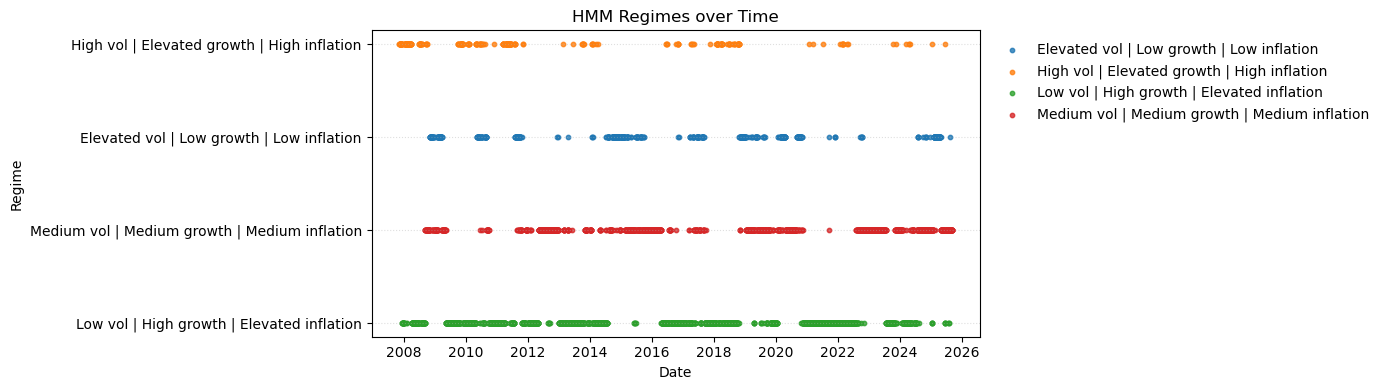

In [32]:
state_idx  = G.values.argmax(1)
state_id   = pd.Series([f"S{i}" for i in state_idx], index=G.index, name="state_id")
state_named = state_id.map(name_map)

# --- Optional: dot plot over time, ignoring the null state ---
active_ids   = state_means['Vol'].sort_values().index.tolist()   # order by Vol level
active_names = [name_map[s] for s in active_ids]
y_map = {nm: i for i, nm in enumerate(active_names)}

mask = state_named.ne("Null (unused)")
fig, ax = plt.subplots(figsize=(14, 4))
for nm, grp in state_named[mask].groupby(state_named[mask]):
    ax.scatter(grp.index, [y_map[nm]] * len(grp), s=10, alpha=0.8, label=nm)

ax.set_yticks(list(y_map.values()))
ax.set_yticklabels(active_names)
ax.set_title("HMM Regimes over Time")
ax.set_xlabel("Date"); ax.set_ylabel("Regime")
ax.grid(True, axis='y', linestyle=':', alpha=0.4)
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0), frameon=False)
plt.tight_layout()

In [33]:
state_named

Date
2007-11-08      High vol | Elevated growth | High inflation
2007-11-09      High vol | Elevated growth | High inflation
2007-11-12      High vol | Elevated growth | High inflation
2007-11-13      High vol | Elevated growth | High inflation
2007-11-14      High vol | Elevated growth | High inflation
                                  ...                      
2025-09-08    Medium vol | Medium growth | Medium inflation
2025-09-09    Medium vol | Medium growth | Medium inflation
2025-09-10    Medium vol | Medium growth | Medium inflation
2025-09-11    Medium vol | Medium growth | Medium inflation
2025-09-12    Medium vol | Medium growth | Medium inflation
Name: state_id, Length: 4452, dtype: object

In [29]:
state_named.to_csv('~/Desktop/PitchBook/All-Weather Portfolio/States',index_label='Date')

# 4. All Weather Portfolio Construction

## 4.1 Test: Permanent Portfolio 

### Dollar Assets: 27.40%
### Aggerssive Growth Stocks: 21.07% 
### Real Estate & Natural Resources Stocks: 17.02% 
### Swiss Franc Assets: 7.73%
### Silver Assets: 4.76% 
### Gold Assets: 21.57%
### Other Assets: 0.45% (Here add to Aggressive Growth Stocks to 21.52%)

Common start: 2009-01-02
Common end  : 2025-09-12

Permanent Portfolio Backtest
Start date          : 2009-01-05
End date            : 2025-09-12
Total return        : 988.37%
CAGR                : 15.38%
Annualized vol      : 14.95%
Sharpe (CAGR/vol)   : 1.03
Max drawdown        : -25.86%


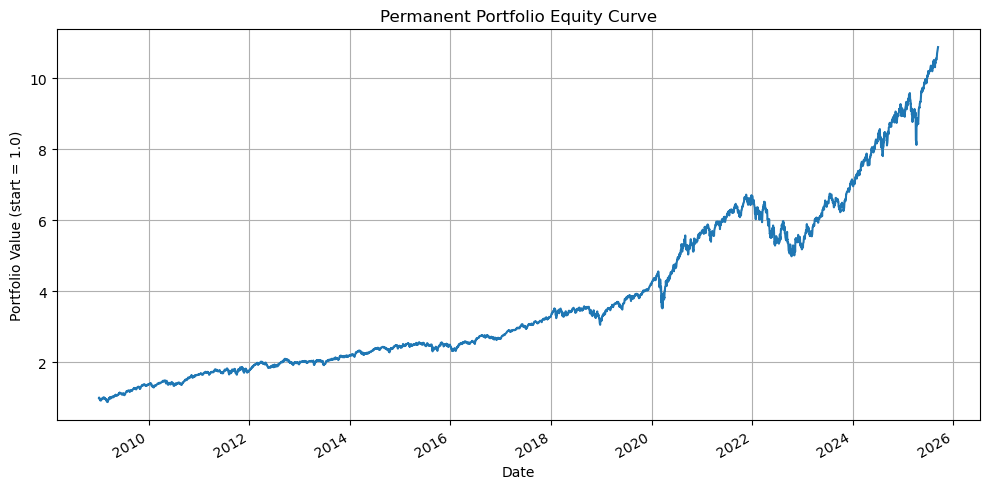

In [34]:
# 1. Helper to load one ETF CSV
def load_etf(path, ticker, price_col='收盘'):
    df = pd.read_csv(path)
    
    df['交易日期'] = pd.to_datetime(df['交易日期'], format='%d-%b-%Y')
    df = df.set_index('交易日期').sort_index()
    
    prices = pd.to_numeric(df[price_col].astype(str).str.replace(',', ''), errors='coerce')
    
    out = pd.DataFrame({ticker: prices})
    out = out.dropna()
    return out

# 2. File paths
base = "Desktop/Data/ETF/ETF Global"

paths = {
    "BND": f"{base}/Index ETFs/BND.csv",
    "GLD": f"{base}/Commodity ETFs/GLD.csv",
    "FXF": f"{base}/Index ETFs/FXF.csv",
    "QQQ": f"{base}/Index ETFs/QQQ.csv",
    "SPY": f"{base}/Index ETFs/SPY.csv",
    "VNQ": f"{base}/Sector ETFs/VNQ.csv",
    "UUP": f"{base}/Index ETFs/UUP.csv",
}

# 3. Load all ETFs & compute returns
price_dfs = []
for ticker, path in paths.items():
    df = load_etf(path, ticker, price_col='收盘')
    price_dfs.append(df)

prices = pd.concat(price_dfs, axis=1, join='inner').sort_index()

starts = {c: prices[c].first_valid_index() for c in prices.columns}
ends   = {c: prices[c].last_valid_index()  for c in prices.columns}

common_start = max(starts.values())
common_start = pd.to_datetime("2009-01-02")
common_end   = min(min(ends.values()), pd.to_datetime("2025-09-12"))

prices = prices.loc[common_start:common_end]

print("Common start:", common_start.date())
print("Common end  :", common_end.date())

rets = prices.pct_change().dropna()

# 4. Portfolio weights
weights_pct = {
    "BND": 0.0,
    "QQQ": 50.0,
    "SPY": 20.0,
    "FXF": 0.0,
    "GLD": 30.0,
    "UUP": 0.0,
}

# Turn into aligned weight vector
w = pd.Series(weights_pct, index=rets.columns) / 100.0

# 5. Portfolio backtest
port_ret = (rets * w).sum(axis=1)
equity = (1 + port_ret).cumprod()

# 6. Performance stats
n_days = (equity.index[-1] - equity.index[0]).days
n_years = n_days / 365.25

total_return = equity.iloc[-1] - 1.0
cagr = equity.iloc[-1] ** (1 / n_years) - 1 if n_years > 0 else np.nan
vol_annual = port_ret.std() * np.sqrt(252)
sharpe = cagr / vol_annual if vol_annual > 0 else np.nan

# Max drawdown
running_max = equity.cummax()
drawdown = equity / running_max - 1
max_dd = drawdown.min()

print("\nPermanent Portfolio Backtest")
print(f"Start date          : {equity.index[0].date()}")
print(f"End date            : {equity.index[-1].date()}")
print(f"Total return        : {total_return:.2%}")
print(f"CAGR                : {cagr:.2%}")
print(f"Annualized vol      : {vol_annual:.2%}")
print(f"Sharpe (CAGR/vol)   : {sharpe:.2f}")
print(f"Max drawdown        : {max_dd:.2%}")

plt.figure(figsize=(10, 5))
equity.plot()
plt.title("Permanent Portfolio Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (start = 1.0)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [470]:
weights_pct = {
    "BND": 27.40,
    "QQQ": 10.76,
    "SPY": 10.76,
    "VNQ": 8.51,
    "GNR": 8.51,
    "FXF": 7.73,
    "GLD": 26.33,
}

## 4.2 All-Weather Portfolio

### 4.2.1 Actual State Based

Regime-based All-Weather Portfolio Backtest
Start date      : 2009-01-05
End date        : 2025-09-12
Total return    :  0.00%
CAGR            :  0.00%
Annualized vol  :  0.00%
Sharpe (CAGR/vol):    nan
Max drawdown    :  0.00%


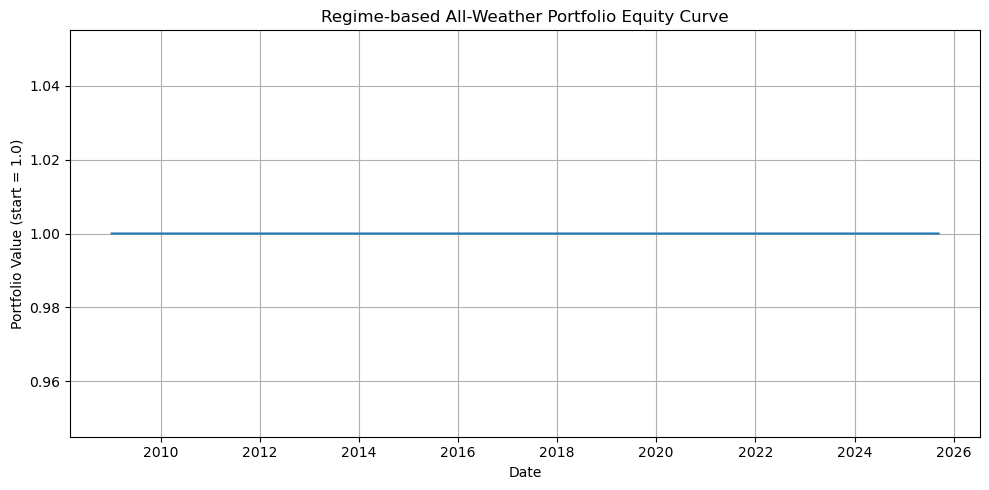

In [35]:
prices.index = pd.to_datetime(prices.index)
state_named.index = pd.to_datetime(state_named.index)

prices = prices.sort_index()
state_named = state_named.sort_index()

# 1. Backtest window
start = pd.Timestamp("2008-01-02")
end   = pd.Timestamp("2025-09-12")

prices_bt = prices.loc[start:end]

returns = prices_bt.pct_change().dropna()

# 2. Regime-based target weights (in fractions, sum to 1)
regime_weights = {
    "Elevated vol | Elevated growth | High inflation": { 
        "BND": 0.3,
        "QQQ": 0.1,
        "SPY": 0.2,
        "FXF": 0.1,
        "GLD": 0.2,
        "UUP": 0.1,
    },
    "Low vol | Medium growth | Medium inflation": {   
        "BND": 0.0,
        "QQQ": 0.6,
        "SPY": 0.1,
        "FXF": 0.0,
        "GLD": 0.3,
        "UUP": 0.0,
    },
    "High vol | Low growth | Low inflation": {   
        "BND": 0.0,
        "QQQ": 0.0,
        "SPY": 0.0,
        "FXF": 0.4,
        "GLD": 0.6,
        "UUP": 0.0,
    },
    "Medium vol | High growth | Elevated inflation": {   
        "BND": 0.0,
        "QQQ": 0.3,
        "SPY": 0.1,
        "FXF": 0.0,
        "GLD": 0.3,
        "UUP": 0.3,
    },
}

tickers = ["BND", "GLD", "FXF", "QQQ", "SPY", "UUP"]

# 3. Build daily weight matrix from regimes

weights_regime = pd.DataFrame(index=state_named.index, columns=tickers, dtype=float)

for dt, reg in state_named.items():
    if dt < start or dt > end:
        continue
    if reg not in regime_weights:
        continue
    # assign row for that regime date
    for t in tickers:
        weights_regime.loc[dt, t] = regime_weights[reg][t]

# Reindex to trading days and forward fill
weights_daily = (
    weights_regime
    .reindex(prices_bt.index)    
    .ffill()                       
)

weights_daily = weights_daily.loc[returns.index]

# 4. Portfolio returns & equity curve
port_rets = (weights_daily * returns[tickers]).sum(axis=1)

equity = (1 + port_rets).cumprod()

# 5. Performance statistics
start_date = equity.index[0]
end_date = equity.index[-1]
n_years = (end_date - start_date).days / 365.25

total_return = equity.iloc[-1] - 1.0
cagr = equity.iloc[-1] ** (1 / n_years) - 1.0
ann_vol = port_rets.std() * np.sqrt(252)
sharpe = cagr / ann_vol if ann_vol != 0 else np.nan

roll_max = equity.cummax()
drawdown = equity / roll_max - 1.0
max_dd = drawdown.min()

print("Regime-based All-Weather Portfolio Backtest")
print(f"Start date      : {start_date.date()}")
print(f"End date        : {end_date.date()}")
print(f"Total return    : {total_return:6.2%}")
print(f"CAGR            : {cagr:6.2%}")
print(f"Annualized vol  : {ann_vol:6.2%}")
print(f"Sharpe (CAGR/vol): {sharpe:6.2f}")
print(f"Max drawdown    : {max_dd:6.2%}")

# 6. Plot equity curve
plt.figure(figsize=(10, 5))
plt.plot(equity.index, equity.values)
plt.title("Regime-based All-Weather Portfolio Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (start = 1.0)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.2.2 Predicted Positioning Logic

In [32]:
# --- 1) Setup & alignment ---
# expected durations (in days) for each state from the transition matrix
K = model.n_components
A = model.transmat_
dur = pd.Series(1.0 / (1.0 - np.clip(np.diag(A), 1e-6, 1-1e-6)),
                index=[f"S{k}" for k in range(K)], name="dur_days")

# one-step-ahead hard prediction for t+1, made at t
pred_state_id = pd.Series(pred.values.argmax(axis=1), index=pred.index).map(lambda i: f"S{i}")
# execute next day: shift by 1 to apply at t (weights decided at t-1)
signal_state_id = pred_state_id.shift(1)

# map state id -> human-readable regime name for weight lookup
signal_name = signal_state_id.map(name_map)

# restrict to backtest window
bt_idx = returns.loc[start:end].index
signal_id_bt   = signal_state_id.reindex(bt_idx)
signal_name_bt = signal_name.reindex(bt_idx)

# --- 2) Build daily weights with "min duration = 5 days" switching rule ---
MIN_DUR = 10.0  # threshold in days

weights_daily = pd.DataFrame(0.0, index=bt_idx, columns=tickers, dtype=float)
last_w = np.zeros(len(tickers))
current_state = None  # track current S{j}

for dt in bt_idx:
    s = signal_id_bt.loc[dt]      # predicted S{j} to use for date dt (decided yesterday)
    if pd.isna(s):
        # no signal yet (first day) -> keep last weights (zeros initially)
        w = last_w
    else:
        # decide whether to switch
        should_switch = (current_state != s) and (dur.loc[s] >= MIN_DUR)
        if should_switch:
            nm = name_map.get(s, None)
            if (nm is not None) and (nm in regime_weights):
                # apply target weights for this regime
                wdict = regime_weights[nm]
                w = np.array([wdict.get(t, 0.0) for t in tickers], dtype=float)
                current_state = s
            else:
                # unknown/null state name → keep last weights
                w = last_w
        else:
            # either same state or predicted state's duration < MIN_DUR → hold
            w = last_w

    weights_daily.loc[dt] = w
    last_w = w

# ensure weights matrix aligns to returns dates (already bt_idx) and forward-fill any gaps
weights_daily = weights_daily.reindex(bt_idx).ffill()

# --- 3) Portfolio returns & equity curve ---
port_rets = (weights_daily * returns.loc[bt_idx, tickers]).sum(axis=1)
equity = (1.0 + port_rets).cumprod()

# quick sanity prints
print("Expected durations (days) per state:")
print(dur.round(2))
print("\nSample of signal state & applied regime:")
display(pd.DataFrame({
    "signal_state": signal_id_bt.tail(10),
    "regime_name":  signal_name_bt.tail(10),
    "switched?":    (weights_daily.diff().abs().sum(axis=1) > 1e-12).tail(10)
}))

Expected durations (days) per state:
S0    23.67
S1    33.00
S2    29.00
S3    30.00
Name: dur_days, dtype: float64

Sample of signal state & applied regime:


,signal_state,regime_name,switched?
交易日期,,,
2025-08-29,S3,Low vol | Medium growth | Medium inflation,False
2025-09-02,S3,Low vol | Medium growth | Medium inflation,False
2025-09-03,S3,Low vol | Medium growth | Medium inflation,False
2025-09-04,S3,Low vol | Medium growth | Medium inflation,False
2025-09-05,S3,Low vol | Medium growth | Medium inflation,False
2025-09-08,S3,Low vol | Medium growth | Medium inflation,False
2025-09-09,S3,Low vol | Medium growth | Medium inflation,False
2025-09-10,S3,Low vol | Medium growth | Medium inflation,False
2025-09-11,S3,Low vol | Medium growth | Medium inflation,False


Regime-based All-Weather Portfolio Backtest
Start date      : 2009-01-05
End date        : 2025-09-12
Total return    : 519.40%
CAGR            : 11.55%
Annualized vol  : 11.28%
Sharpe (CAGR/vol):   1.02
Max drawdown    : -21.21%


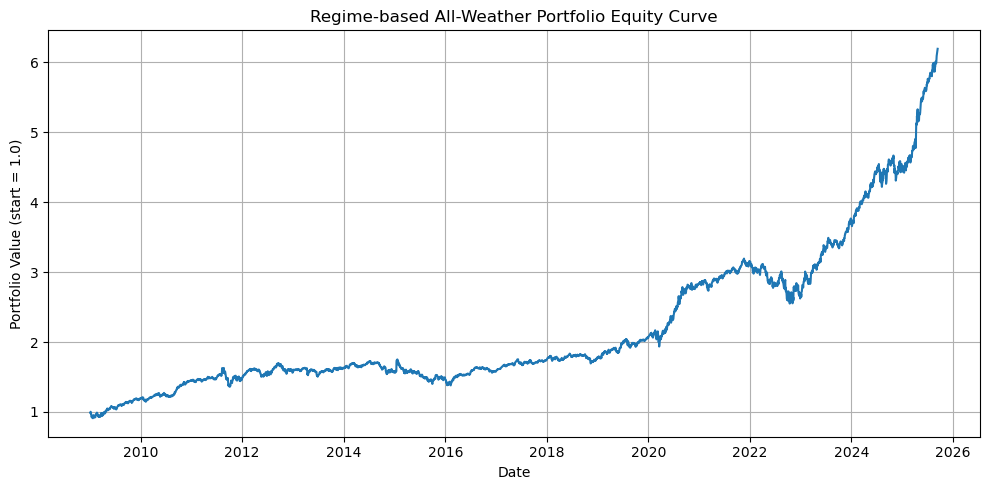

In [33]:
# 5. Performance statistics
start_date = equity.index[0]
start_date = pd.to_datetime("2009-01-05")
end_date = equity.index[-1]
n_years = (end_date - start_date).days / 365.25

total_return = equity.iloc[-1] - 1.0
cagr = equity.iloc[-1] ** (1 / n_years) - 1.0
ann_vol = port_rets.std() * np.sqrt(252)
sharpe = cagr / ann_vol if ann_vol != 0 else np.nan

roll_max = equity.cummax()
drawdown = equity / roll_max - 1.0
max_dd = drawdown.min()

print("Regime-based All-Weather Portfolio Backtest")
print(f"Start date      : {start_date.date()}")
print(f"End date        : {end_date.date()}")
print(f"Total return    : {total_return:6.2%}")
print(f"CAGR            : {cagr:6.2%}")
print(f"Annualized vol  : {ann_vol:6.2%}")
print(f"Sharpe (CAGR/vol): {sharpe:6.2f}")
print(f"Max drawdown    : {max_dd:6.2%}")

# 6. Plot equity curve
plt.figure(figsize=(10, 5))
plt.plot(equity.index, equity.values)
plt.title("Regime-based All-Weather Portfolio Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (start = 1.0)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# 1) Build a tidy table: state id, regime name, and weights per asset
state_pos = pd.concat(
    [
        signal_id_bt.rename("signal_state"),     # e.g. 'S0', 'S1', ...
        signal_name_bt.rename("regime_name"),    # human-readable name
        weights_daily.add_prefix("w_"),          # w_BND, w_GLD, ...
    ],
    axis=1
)

# 2) Flag days when the portfolio actually switched to a new regime's weights
state_pos["switched"] = weights_daily.diff().abs().sum(axis=1) > 1e-12

# 3) Quick look
display(state_pos.tail(20))

# 4) Save to csv so you can inspect in Excel
out_path = "~/Desktop/PitchBook/All-Weather Portfolio/Regime_&_Positioning"
state_pos.to_csv(out_path, index_label="Date")
print("Saved state & positioning table to:", out_path)

,signal_state,regime_name,w_BND,w_GLD,w_FXF,w_QQQ,w_SPY,w_UUP,switched
交易日期,,,,,,,,,
2025-08-15,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-18,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-19,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-20,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-21,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-22,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-25,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-26,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False
2025-08-27,S3,Low vol | Medium growth | Medium inflation,0.0,0.3,0.0,0.6,0.1,0.0,False


Saved state & positioning table to: ~/Desktop/PitchBook/All-Weather Portfolio/Regime_&_Positioning


## 4.3 Cost Model Implementation